In [303]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time

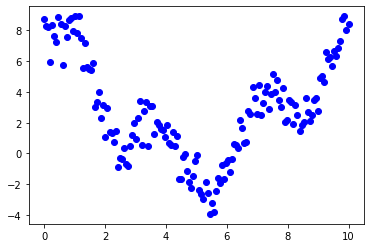

In [304]:
n = 150
X_data = np.linspace(0,10,n)
X_data = X_data.reshape((n,1))
Y_data = np.sin(X_data) + 2* np.sin(2 * X_data) + 0.3 * (X_data - 5)**2 
# data_no_noise = np.concatenate((X_data, Y_data), axis=1)

Y_data += np.random.normal(0, 1, [n,1])

plt.plot(X_data, Y_data, 'bo')
plt.show()

In [305]:
data = np.concatenate((X_data, Y_data), axis=1)

np.random.shuffle(data)

data_tr, data_val= np.split(data, [int(0.8*n)], axis = 0)
print(data_tr.shape, data_val.shape)
n_tr, n_val = data_tr.shape[0], data_val.shape[0]

(120, 2) (30, 2)


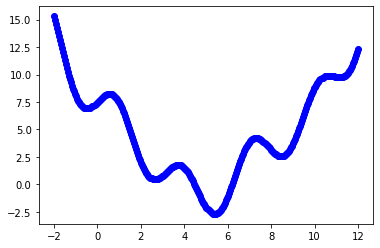

In [306]:
n_eval = 300
X_data = np.linspace(-2,12,n_eval)
X_data = X_data.reshape((n_eval,1))
Y_data = np.sin(X_data) + 2* np.sin(2 * X_data) + 0.3 * (X_data - 5)**2 

plt.plot(X_data, Y_data, 'bo')
plt.show()

data_eval = np.concatenate((X_data, Y_data), axis=1)

In [307]:
def next_batch(data_tr, i, batch_size):
    return data_tr[i*batch_size:(i+1)*batch_size-1, :]  

In [308]:
# Parameters
learning_rate = 0.02
num_epochs = 4000
batch_size = n_tr // 1
itpep = n_tr // batch_size
# display_step = 100
snap_step = 500
wd_par = 0.1

# Network Parameters
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 512 # 2nd layer number of neurons
num_input = 1 
num_output = 1 

# tf Graph input
X = tf.placeholder(tf.float32, shape = [None, 1])
Y = tf.placeholder(tf.float32, shape = [None, 1])

In [309]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

In [310]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer 
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

In [311]:
fp = neural_net(X)
error = tf.reduce_sum(tf.pow(fp-Y, 2))

loss = n_tr / batch_size * tf.reduce_sum(tf.pow(fp-Y, 2)) \
                + wd_par * tf.reduce_sum([tf.reduce_sum(tf.pow(weights[i], 2)) for i in weights])

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

Optimization 1 out of 3 finished!
Optimization 2 out of 3 finished!
Optimization 3 out of 3 finished!


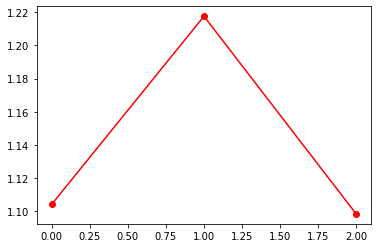

In [312]:
errors = []
opt_weights = []
opt_biases = []

init_weights = []
init_biases = []

sess = tf.Session()

num = 3
snaps = list(range(num))

snap_weights = {k: [] for k in snaps} # be careful! not zip!
snap_biases = {k: [] for k in snaps}

for c in range(num):
    
    #############################################################
    sess.run(init)
    
    init_weights.append(sess.run(weights))
    init_biases.append(sess.run(biases))
    #############################################################
    i = 0

    for iteration in range(num_epochs * itpep):
        if (iteration + 1) % (snap_step * itpep) == 0 or iteration == 0:
            snap_weights[c].append(sess.run(weights))
            snap_biases[c].append(sess.run(biases)) # before update
            
        data_batch = next_batch(data_tr, i, batch_size)
        sess.run(train_op, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]]})

        if (iteration + 1) % itpep == 0:
            i = 0
        else:
            i += 1
                
    print('Optimization %.1d out of %.1d finished!' %(c+1, num))
    
    errors.append(sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}) / n_val)
    opt_weights.append(sess.run(weights))
    opt_biases.append(sess.run(biases))
    
plt.plot(errors, 'ro-')
plt.show()

In [313]:
ensemble = np.zeros(data_eval[:, [0]].shape)
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    
    ensemble += sess.run(fp, feed_dict = {X: data_eval[:, [0]]}) / num

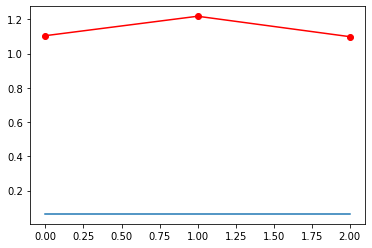

In [314]:
ens_error = tf.reduce_sum(tf.pow(ensemble-Y, 2)) / n_eval
ens_error = sess.run(ens_error, feed_dict = {Y: data_eval[:, [1]]}) / n_val

plt.plot([0, num - 1], ens_error * np.ones(2), label = 'ensemble error')
plt.plot(errors, 'ro-', label = 'ind error')
plt.show()

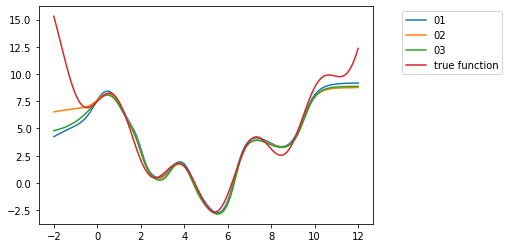

In [50]:
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    
    plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = '%.2d' %(c+1))
    
plt.plot(data_eval[:, [0]], data_eval[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

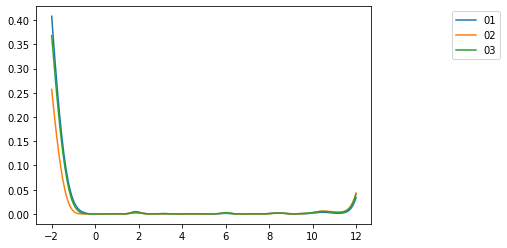

In [51]:
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    temp_error = sess.run(tf.pow(fp-Y, 2) / n_eval, feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]})
    
    plt.plot(data_eval[:, [0]], temp_error, label = '%.2d' %(c+1))
    
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

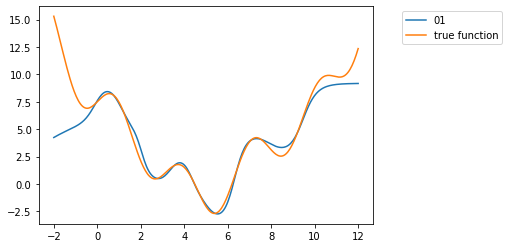

In [52]:
weights = opt_weights[0]
biases = opt_biases[0]
fp = neural_net(X)
    
plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = '%.2d' %(0+1))
    
plt.plot(data_eval[:, [0]], data_eval[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

In [315]:
import itertools
flatten = itertools.chain.from_iterable

def dictovec(a):
    avec = np.array(list(flatten([val.flatten() for val in a.values()])))
    return avec

def shapeslengths(a):
    return [val.shape for val in a.values()], [len(val.flatten()) for val in a.values()]

def vectodict(avec, keys, shapes, lengths):
    l = []
    k = 0
    for i, s in enumerate(shapes):
        l.append(avec[k:k+lengths[i]].reshape(s))
        k += lengths[i]
    a = dict(zip(keys, l))
    return a

def abtovec(a, b):
    return np.concatenate((dictovec(a), dictovec(b)))

def cvectodict(cvec, akeys, bkeys, sa, la, sb, lb):
    avec = cvec[:sum(la)]
    bvec = cvec[sum(la):]
    
    return vectodict(avec, list(akeys), sa, la), vectodict(bvec, list(bkeys), sb, lb)

In [316]:
sw, lw = shapeslengths(opt_weights[0])
sb, lb = shapeslengths(opt_biases[0])
wkeys = opt_weights[0].keys()
bkeys = opt_biases[0].keys()

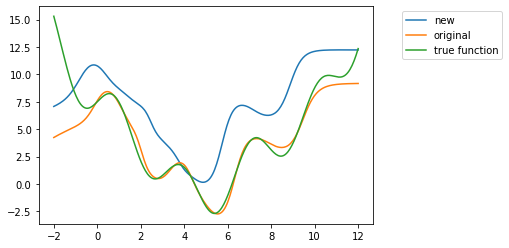

In [55]:
w1 = opt_weights[0]
b1 = opt_biases[0]

wb1vec = abtovec(w1, b1)

par = 0.01
wb1vec_new = wb1vec + par

weights, biases = cvectodict(wb1vec_new, wkeys, bkeys, sw, lw, sb, lb)

fp = neural_net(X)
plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'new')

weights = opt_weights[0]
biases = opt_biases[0]
fp = neural_net(X)
plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'original')
    
plt.plot(data_eval[:, [0]], data_eval[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

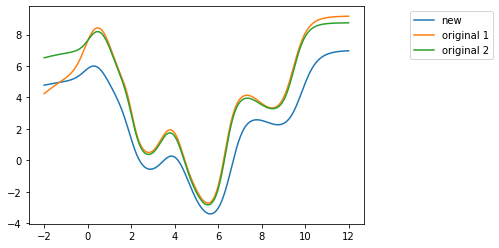

In [56]:
par = 0.1
w1 = opt_weights[0]
w2 = opt_weights[1]
b1 = opt_biases[0]
b2 = opt_biases[1]

wb1vec = abtovec(w1, b1)
wb2vec = abtovec(w2, b2)

wbvec_new = par * wb1vec + (1 - par) * wb2vec
weights, biases = cvectodict(wbvec_new, wkeys, bkeys, sw, lw, sb, lb)

fp = neural_net(X)
plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'new')

weights = opt_weights[0]
biases = opt_biases[0]
fp = neural_net(X)
plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'original 1')

weights = opt_weights[1]
biases = opt_biases[1]
fp = neural_net(X)
plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'original 2')
    
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()


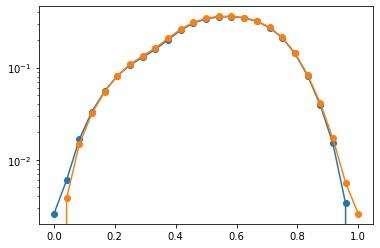

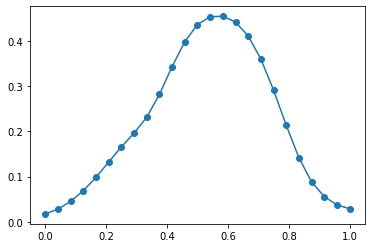

In [57]:
w1 = opt_weights[0]
b1 = opt_biases[0]

w2 = opt_weights[1]
b2 = opt_biases[1]
#########################################################################################################################
wb1vec = abtovec(w1, b1)
wb2vec = abtovec(w2, b2)

weights = w1
biases = b1
fp = neural_net(X)
pred_1 = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})

weights = w2
biases = b2
fp = neural_net(X)
pred_2 = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})

error_1 = []
error_2 = []
error_line = []

pars = np.linspace(0, 1, 25)

for par in pars:
    wbvec_new = par * wb1vec + (1 - par) * wb2vec
    weights, biases = cvectodict(wbvec_new, wkeys, bkeys, sw, lw, sb, lb)

    fp = neural_net(X)
    error = tf.reduce_sum(tf.pow(fp-Y, 2)) / n_eval
    
    pred = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})
    
    error_1.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: pred_1}) / n)
    error_2.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: pred_2}) / n)
    
    error_line.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]}) / n)

plt.yscale('log')
plt.plot(pars, error_1, '-o')
plt.plot(pars, error_2, '-o')
plt.show()

plt.plot(pars, error_line, '-o')
plt.show()

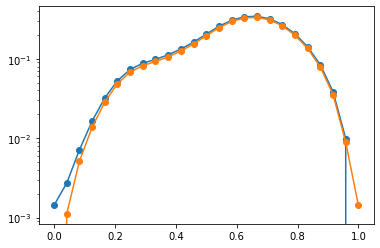

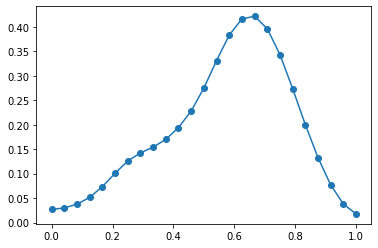

In [58]:
w1 = opt_weights[1]
b1 = opt_biases[1]

w2 = opt_weights[2]
b2 = opt_biases[2]
#########################################################################################################################
wb1vec = abtovec(w1, b1)
wb2vec = abtovec(w2, b2)

weights = w1
biases = b1
fp = neural_net(X)
pred_1 = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})

weights = w2
biases = b2
fp = neural_net(X)
pred_2 = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})

error_1 = []
error_2 = []
error_line = []

pars = np.linspace(0, 1, 25)

for par in pars:
    wbvec_new = par * wb1vec + (1 - par) * wb2vec
    weights, biases = cvectodict(wbvec_new, wkeys, bkeys, sw, lw, sb, lb)

    fp = neural_net(X)
    error = tf.reduce_sum(tf.pow(fp-Y, 2)) / n_eval
    
    pred = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})
    
    error_1.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: pred_1}) / n)
    error_2.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: pred_2}) / n)
    
    error_line.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]}) / n)

plt.yscale('log')
plt.plot(pars, error_1, '-o')
plt.plot(pars, error_2, '-o')
plt.show()

plt.plot(pars, error_line, '-o')
plt.show()

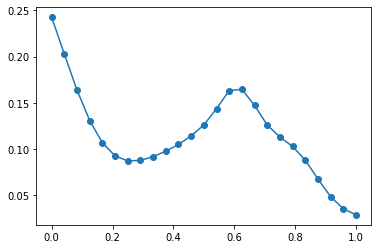

In [59]:
w1 = opt_weights[0]
b1 = opt_biases[0]

w2 = init_weights[0]
b2 = init_biases[0]
#########################################################################################################################
wb1vec = abtovec(w1, b1)
wb2vec = abtovec(w2, b2)

weights = w1
biases = b1
fp = neural_net(X)
pred_1 = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})

weights = w2
biases = b2
fp = neural_net(X)
pred_2 = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})

error_1 = []
error_2 = []
error_line = []

pars = np.linspace(0, 1, 25)

for par in pars:
    wbvec_new = par * wb1vec + (1 - par) * wb2vec
    weights, biases = cvectodict(wbvec_new, wkeys, bkeys, sw, lw, sb, lb)

    fp = neural_net(X)
    error = tf.reduce_sum(tf.pow(fp-Y, 2)) / n_eval
    
    pred = sess.run(fp, feed_dict = {X: data_eval[:, [0]]})
    
    error_1.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: pred_1}) / n)
    error_2.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: pred_2}) / n)
    
    error_line.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]}) / n)

plt.plot(pars, error_line, '-o')
plt.show()

In [317]:
w1 = opt_weights[0]
b1 = opt_biases[0]

w2 = opt_weights[1]
b2 = opt_biases[1]

wb1vec = abtovec(w1, b1)
wb2vec = abtovec(w2, b2)

uvec = wb2vec - wb1vec
u_sq = sum([x**2 for x in uvec])
u_norm = np.sqrt(u_sq)

u_hat_vec = uvec / u_norm
u_hat_w, u_hat_b = cvectodict(u_hat_vec, wkeys, bkeys, sw, lw, sb, lb)

w3 = opt_weights[2]
b3 = opt_biases[2]

wb3vec = abtovec(w3, b3)

w3mw1vec = wb3vec - wb1vec

inner = sum([x * y for x, y in zip(uvec, w3mw1vec)])

vvec = w3mw1vec - inner / u_sq * uvec
v_sq = sum([x**2 for x in vvec])
v_norm = np.sqrt(v_sq)

v_hat_vec = vvec / v_norm
v_hat_w, v_hat_b = cvectodict(v_hat_vec, wkeys, bkeys, sw, lw, sb, lb)

In [37]:
# meshgrid test

# n1 = np.linspace(0, 1, 6)
# n2 = np.linspace(0, 100, 6)

# n1v, n2v = np.meshgrid(n1, n2)

# print(n1v)
# print(n2v)

# Z = []
# for i in n1:
#     Z_i = []
#     for j in n2:
#         Z_i.append(j)
#     Z.append(Z_i)
# print(np.array(Z).transpose())

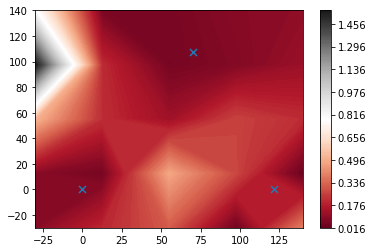

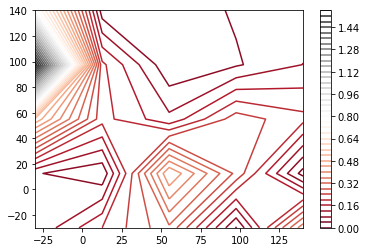

In [188]:
pars = np.linspace(-30, 140, 5)

error_mat = []

for par_1 in pars:
    error_v = []
    for par_2 in pars:
        
        wbvec_new = wb1vec + par_1 * u_hat_vec + par_2 * v_hat_vec
        weights, biases = cvectodict(wbvec_new, wkeys, bkeys, sw, lw, sb, lb)
        
        fp = neural_net(X)
        error = tf.reduce_sum(tf.pow(fp-Y, 2)) / n_eval
        
        error_v.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]}) / n)

    error_mat.append(error_v)  
                
xx, yy = np.meshgrid(pars, pars)

plt.contourf(xx, yy, np.array(error_mat).transpose(), 200, origin='lower', cmap='RdGy')
plt.colorbar()
plt.scatter([0, u_norm, inner / u_norm], [0, 0, v_norm], marker = 'x', s = 50)
plt.show()

plt.contour(xx, yy, np.array(error_mat).transpose(), 40, origin='lower', cmap='RdGy')
plt.colorbar()
plt.show()

In [320]:
def projtoplane(wvec, wb1vec, u_hat_vec, v_hat_vec):
    
    basis = np.concatenate((u_hat_vec.reshape(-1,1), v_hat_vec.reshape(-1,1)), axis = 1)

    ata = np.linalg.inv(np.matmul(basis.transpose(), basis))

    pr = wb1vec + np.matmul(basis, np.matmul(ata, np.matmul(basis.transpose(), wvec - wb1vec)))

    prx, pry = np.linalg.solve(np.concatenate((u_hat_vec[:2].reshape(-1,1), \
                                             v_hat_vec[:2].reshape(-1,1)), axis = 1), pr[:2] - wb1vec[:2])
    
    return prx, pry

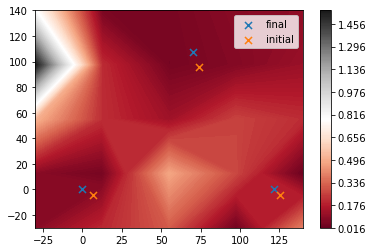

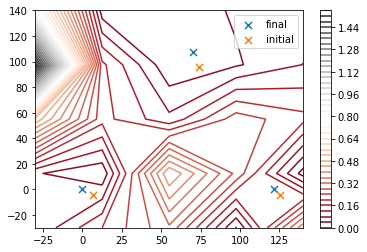

In [237]:
basis = np.concatenate((u_hat_vec.reshape(-1,1), v_hat_vec.reshape(-1,1)), axis = 1)

ata = np.linalg.inv(np.matmul(basis.transpose(), basis))

projections_x = []
projections_y = []

for c in range(num):
    for snap in range(len(snap_weights[0])): 
        prx, pry = projtoplane(abtovec(snap_weights[c][snap], snap_biases[c][snap]), wb1vec, u_hat_vec, v_hat_vec)
        projections_x.append(prx)
        projections_y.append(pry)
        
# pr1x, pr1y = projtoplane(abtovec(init_weights[0], init_biases[0]), wb1vec, u_hat_vec, v_hat_vec)
# pr2x, pr2y = projtoplane(abtovec(init_weights[1], init_biases[1]), wb1vec, u_hat_vec, v_hat_vec)
# pr3x, pr3y = projtoplane(abtovec(init_weights[2], init_biases[2]), wb1vec, u_hat_vec, v_hat_vec)

plt.contourf(xx, yy, np.array(error_mat).transpose(), 200, origin='lower', cmap='RdGy')
plt.colorbar()

plt.scatter([0], [0], marker = 'x', s = 50, label = 'origin')
plt.scatter([u_norm, inner / u_norm], [0, v_norm], marker = 'x', s = 50, label = 'final')
plt.scatter([projections_x[0], projections_x[len(snap_weights[0])], projections_x[2 * len(snap_weights[0])]] \
            , [projections_y[0],  projections_y[len(snap_weights[0])], projections_y[2 * len(snap_weights[0])]], marker = 'x', s = 50, label = 'initial')
plt.scatter(projections_x[1:], projections_y[1:], marker = '.', s = 5, label = 'snaps')
# plt.scatter([0, u_norm, inner / u_norm], [0, 0, v_norm], marker = 'x', s = 50, label = 'final')
# plt.scatter([pr1x, pr2x, pr3x], [pr1y, pr2y, pr3y], marker = 'x', s = 50, label = 'initial')
plt.legend()
plt.show()

plt.contour(xx, yy, np.array(error_mat).transpose(), 40, origin='lower', cmap='RdGy')
plt.colorbar()
plt.scatter([0], [0], marker = 'x', s = 50, label = 'origin')
plt.scatter([u_norm, inner / u_norm], [0, v_norm], marker = 'x', s = 50, label = 'final')
plt.scatter([projections_x[0], projections_x[len(snap_weights[0])]] \
            , [projections_y[0],  projections_y[len(snap_weights[0])]], marker = 'x', s = 50, label = 'initial')
plt.scatter(projections_x[1:], projections_y[1:], marker = '.', s = 5, label = 'snaps')
plt.legend()
plt.show()

94.00312950249223


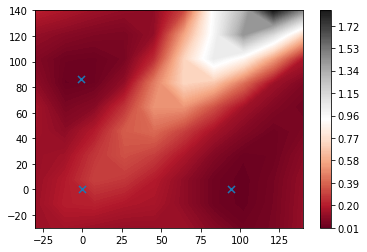

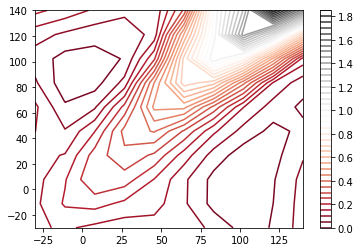

In [321]:
zerovec = np.float32(np.zeros(abtovec(opt_weights[0], opt_biases[0]).shape))
w1, b1 = cvectodict(zerovec, wkeys, bkeys, sw, lw, sb, lb)

w2 = opt_weights[1]
b2 = opt_biases[1]

wb1vec = abtovec(w1, b1)
wb2vec = abtovec(w2, b2)

uvec = wb2vec - wb1vec
u_sq = sum([x**2 for x in uvec])
u_norm = np.sqrt(u_sq)

u_hat_vec = uvec / u_norm
u_hat_w, u_hat_b = cvectodict(u_hat_vec, wkeys, bkeys, sw, lw, sb, lb)

print(u_norm)

w3 = opt_weights[2]
b3 = opt_biases[2]

wb3vec = abtovec(w3, b3)

w3mw1vec = wb3vec - wb1vec

inner = sum([x * y for x, y in zip(uvec, w3mw1vec)])

vvec = w3mw1vec - inner / u_sq * uvec
v_sq = sum([x**2 for x in vvec])
v_norm = np.sqrt(v_sq)

v_hat_vec = vvec / v_norm
v_hat_w, v_hat_b = cvectodict(v_hat_vec, wkeys, bkeys, sw, lw, sb, lb)

pars = np.linspace(-30, 140, 10)

error_mat = []

for par_1 in pars:
    error_v = []
    for par_2 in pars:
        
        wbvec_new = wb1vec + par_1 * u_hat_vec + par_2 * v_hat_vec
        weights, biases = cvectodict(wbvec_new, wkeys, bkeys, sw, lw, sb, lb)
        
        fp = neural_net(X)
        error = tf.reduce_sum(tf.pow(fp-Y, 2)) / n_eval
        
        error_v.append(sess.run(error, feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]}) / n)

    error_mat.append(error_v)  
                
xx, yy = np.meshgrid(pars, pars)

plt.contourf(xx, yy, np.array(error_mat).transpose(), 200, origin='lower', cmap='RdGy')
plt.colorbar()
plt.scatter([0, u_norm, inner / u_norm], [0, 0, v_norm], marker = 'x', s = 50)
plt.show()

plt.contour(xx, yy, np.array(error_mat).transpose(), 40, origin='lower', cmap='RdGy')
plt.colorbar()
plt.show()

In [322]:
zerovec = np.float32(np.zeros(abtovec(opt_weights[0], opt_biases[0]).shape))
w1, b1 = cvectodict(zerovec, wkeys, bkeys, sw, lw, sb, lb)

w2 = opt_weights[1]
b2 = opt_biases[1]

wb1vec = abtovec(w1, b1)
wb2vec = abtovec(w2, b2)

uvec = wb2vec - wb1vec
u_sq = sum([x**2 for x in uvec])
u_norm = np.sqrt(u_sq)

u_hat_vec = uvec / u_norm
u_hat_w, u_hat_b = cvectodict(u_hat_vec, wkeys, bkeys, sw, lw, sb, lb)

# print(u_norm)

w3 = opt_weights[2]
b3 = opt_biases[2]

wb3vec = abtovec(w3, b3)

w3mw1vec = wb3vec - wb1vec

inner = sum([x * y for x, y in zip(uvec, w3mw1vec)])

vvec = w3mw1vec - inner / u_sq * uvec
v_sq = sum([x**2 for x in vvec])
v_norm = np.sqrt(v_sq)

v_hat_vec = vvec / v_norm
v_hat_w, v_hat_b = cvectodict(v_hat_vec, wkeys, bkeys, sw, lw, sb, lb)


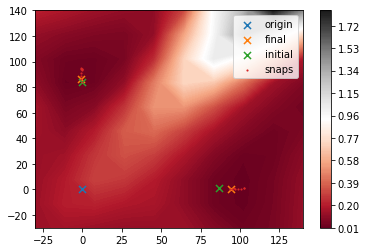

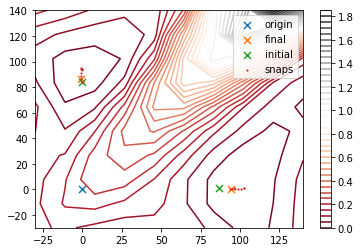

In [333]:
basis = np.concatenate((u_hat_vec.reshape(-1,1), v_hat_vec.reshape(-1,1)), axis = 1)

ata = np.linalg.inv(np.matmul(basis.transpose(), basis))

projections_x = []
projections_y = []

for c in [1, 2]:
    for snap in range(len(snap_weights[0])): 
        prx, pry = projtoplane(abtovec(snap_weights[c][snap], snap_biases[c][snap]), wb1vec, u_hat_vec, v_hat_vec)
        projections_x.append(prx)
        projections_y.append(pry)

xx, yy = np.meshgrid(pars, pars)

plt.contourf(xx, yy, np.array(error_mat).transpose(), 200, origin='lower', cmap='RdGy')
plt.colorbar()
plt.scatter([0], [0], marker = 'x', s = 50, label = 'origin')
plt.scatter([u_norm, inner / u_norm], [0, v_norm], marker = 'x', s = 50, label = 'final')
plt.scatter([projections_x[0], projections_x[len(snap_weights[0])]] \
            , [projections_y[0],  projections_y[len(snap_weights[0])]], marker = 'x', s = 50, label = 'initial')
plt.scatter(projections_x[1:], projections_y[1:], marker = '.', s = 5, label = 'snaps')
plt.legend()
plt.show()

plt.contour(xx, yy, np.array(error_mat).transpose(), 40, origin='lower', cmap='RdGy')
plt.colorbar()
plt.scatter([0], [0], marker = 'x', s = 50, label = 'origin')
plt.scatter([u_norm, inner / u_norm], [0, v_norm], marker = 'x', s = 50, label = 'final')
plt.scatter([projections_x[0], projections_x[len(snap_weights[0])]] \
            , [projections_y[0],  projections_y[len(snap_weights[0])]], marker = 'x', s = 50, label = 'initial')
plt.scatter(projections_x[1:], projections_y[1:], marker = '.', s = 5, label = 'snaps')
plt.legend()
plt.show()